In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from sim_pipeline.galaxy_galaxy_lens_pop import GalaxyGalaxyLensPop
from sim_pipeline.Plots.galaxy_galaxy_plots import GalaxyGalaxyLensingPlots
import numpy as np
import corner


/Users/padmavenkatraman/Documents/StrongLensing/silver/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Galaxy-galaxy simulations

This notebook walks through the basics of simulating a galaxy-galaxy strong lensing population.
The underlying 

assumptions of the galaxy populations (for both lenses and sources) are drawn from a population pre-configured

 and rendered through [SkyPy](https://github.com/skypyproject/skypy). The specific settings are described in the [readme file](https://github.com/LSST-strong-lensing/sim-pipeline/tree/gg-lensing/data/SkyPy).

The notebook goes in three steps:

1. The populations of lenses and sources is produced.
2. Random draws of the population are generated and realized as images
3. The full population is generated in catalogue form
4. the full population is represented in a corner plot



## Generate population of galaxies and (potential) deflectors
The GalaxyGalaxyLensPop() class in the sim-pipeline package is used to produce a set of galaxies (as lenses and sources)

as seen on the sky within a certain sky area.
We use the default SkyPy configuration file. Alternative configuration

files can be used.

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit='deg2')


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {'band': 'g', 'band_max':28, 'z_min': 0.01, 'z_max': 2.5}
kwargs_source_cut = {'band': 'g', 'band_max':28, 'z_min': 0.1, 'z_max': 5.}

# run skypy pipeline and make galaxy-galaxy population class using GalaxyGalaxyLensPop
gg_lens_pop = GalaxyGalaxyLensPop(deflector_type='all-galaxies', source_type='galaxies', 
                        kwargs_deflector_cut=kwargs_deflector_cut, kwargs_source_cut=
                        kwargs_source_cut, kwargs_mass2light=None, skypy_config=None, 
                        sky_area=sky_area, cosmo=cosmo)


`gg_lens_pop` is an object that contains information about galaxies lensed by other galaxies. It has the following attributes:
1. deflector_number()
2. source_number()

In [8]:
gg_lens_pop.potential_deflector_number()

49079

In [9]:
gg_lens_pop.potential_source_number()

232205

## Generate images of random lenses
The GalaxyGalaxyLensingPlots() class has the functionality to draw random lenses and makes an image of it.
Currently

default settings in lenstronomy are chosen for the LSST image settings. These will be able to be replaced with the

LSST simulation tools.

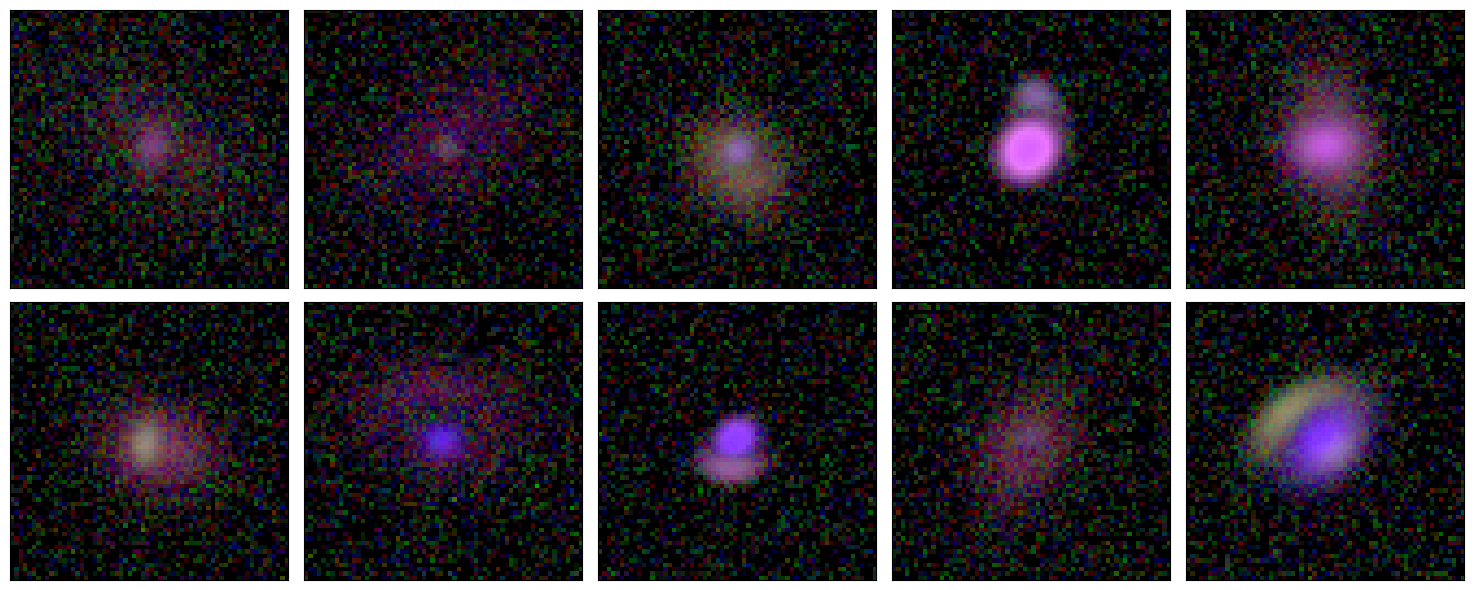

In [47]:
# make some cuts in the image separations and limited magnitudes of the arc 
kwargs_lens_cut_plot = {'min_image_separation': 0.8, 'max_image_separation': 10, 
                        'mag_arc_limit': {'g': 23, 'r': 23, 'i': 23}}


gg_plot = GalaxyGalaxyLensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)

# generate montage indicating which bands are used for the rgb color image
# rgb_band_list must contain 3 elements - they are referred to 'r', 'g', 'b'
# in the code, but accept u, g, r, i, z, y (LSST bands)
fig, axes = gg_plot.plot_montage(rgb_band_list=['r', 'g', 'i'], add_noise=True, n_horizont=5, 
                                 n_vertical=2, kwargs_lens_cut=kwargs_lens_cut_plot)
plt.show()

## Generate the full population
We are using the instance of the GalaxyGalaxyLensPop() class to draw the full population within specified cuts in a Monte Carlo process.

In [24]:
# specifying cuts of the population
kwargs_lens_cuts = {'mag_arc_limit': {'g': 28}}
# drawing population
gg_lens_population = gg_lens_pop.draw_sample(kwargs_lens_cuts=kwargs_lens_cuts)

In [25]:
len(gg_lens_population)

3640

In [26]:
first_lens = gg_lens_population[0]
first_lens

In [28]:
first_lens.deflector_redshift

0.81359822387453

## Represent key quantities of full population in corner plots
We calculate few key quantities of the lenses. The full population is represented each with a GalaxyGalaxyLens() class

object that allows to compute and return these (and more) quantities.

In [31]:
print('Number of lenses:', len(gg_lens_population))

lens_samples = []
labels = [r'$\sigma_v$', r'$\log(M_{*})$', r'$\theta_E$', r'$z_{\rm l}$', r'$z_{\rm s}$', 
          r'$m_{\rm source}$', r'$m_{\rm lens}$']

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band='g', lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band='g')
    lens_samples.append([vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag])



Number of lenses: 3640


In [32]:
lens_samples

[[200.62970767283227,
  9.885375431031905,
  0.7056779964735592,
  0.81359822387453,
  4.372923230570589,
  25.03950508030041,
  23.903498498464476],
 [232.2239867188186,
  10.452413708418316,
  0.8456905023163542,
  0.9004715766779096,
  3.780287106172253,
  26.15498362990706,
  23.83259241873173],
 [148.80740181062671,
  8.92657740651387,
  0.400612207407008,
  0.5414004220291706,
  3.2499739849279474,
  26.133125301268112,
  26.89782956221624],
 [200.09795264460453,
  9.872501604528015,
  0.47389118189276974,
  1.3365006645067523,
  3.2987557073830103,
  25.300073254786174,
  26.92796173121637],
 [207.20265728114936,
  10.039550225973226,
  1.0460014739101968,
  0.32590804489403863,
  4.7270738779371095,
  25.805087862881944,
  22.73147886979575],
 [211.1902444381473,
  10.103668225509347,
  0.38597080971465,
  1.9164440555815851,
  4.0653741323800885,
  27.03053184017436,
  26.675044989422197],
 [313.6940718372644,
  11.400786458034805,
  1.3400179791707603,
  1.2526803359404726,
 

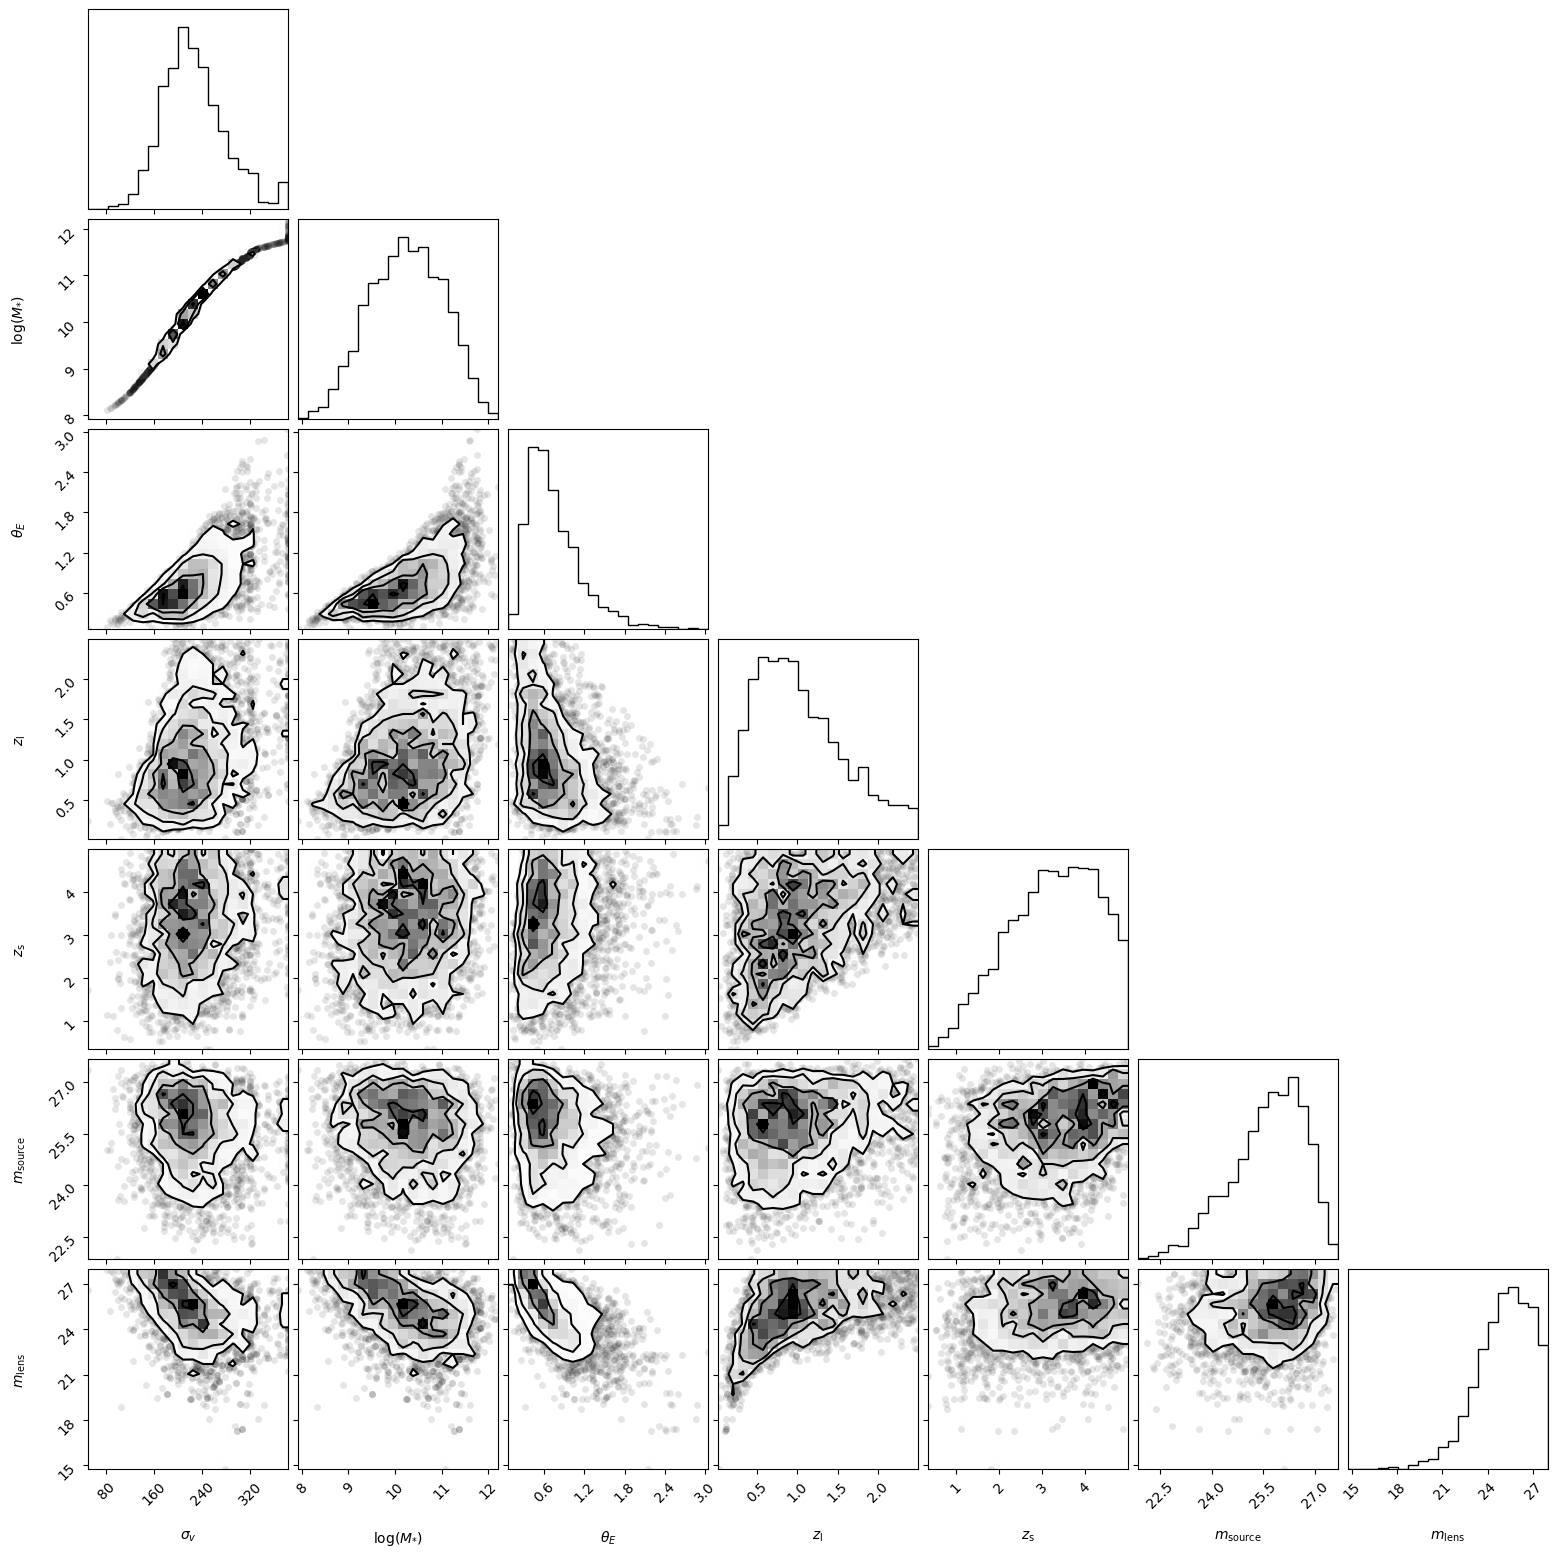

In [33]:
hist2dkwargs = {'plot_density':True, 'plot_contours':True, 'plot_datapoints': True, 'color': 'k',
               'data_kwargs': {'ms': 5}}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()